In [1]:
import random
import time

import pandas as pd
import pretty_midi
import tensorflow as tf
from matplotlib import pyplot as plt

from data.load_data import *

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

seed = 2022
tf.random.set_seed(seed)
np.random.seed(seed)

Num GPUs Available:  1


In [11]:
print("Loading data...")
dataset = load_note_data(use_cache=True).reshape((86080, 3))
key_order = ["pitch", "delay", "duration"]
print(f">> {dataset.shape}")
note_count = len(dataset)

Loading data...
>> (86080, 3)


In [12]:
print("Creating tensorflow dataset...")
notes_dataset = tf.data.Dataset.from_tensor_slices(dataset)
print(f">> {notes_dataset.element_spec}")

Creating tensorflow dataset...
>> TensorSpec(shape=(3,), dtype=tf.float64, name=None)


In [13]:
def create_sequences(dataset: tf.data.Dataset, seq_length: int, vocab_size=128) -> tf.data.Dataset:
    """ Returns TF Dataset of sequence and label examples """
    seq_length = seq_length + 1

    # Take 1 extra for the labels
    windows = dataset.window(seq_length, shift=1, stride=1, drop_remainder=True)

    # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    # Normalize note pitch
    def scale_pitch(x):
        return x / [vocab_size, 1.0, 1.0]

    # Split the labels
    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key: labels_dense[i] for i, key in enumerate(key_order)}

        return scale_pitch(inputs), labels

    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)


seq_length = 64
vocab_size = 128  # range of pitches supported in pretty_midi
sequence_dataset = create_sequences(notes_dataset, seq_length, vocab_size)
sequence_dataset.element_spec

(TensorSpec(shape=(64, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'delay': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [14]:
for seq, target in sequence_dataset.take(3):
    print('sequence shape:', seq.shape)
    print('sequence elements (first 5):', seq[0: 5])
    print('target:', target)

sequence shape: (64, 3)
sequence elements (first 5): tf.Tensor(
[[0.5390625 0.        0.5      ]
 [0.5546875 0.5       0.5      ]
 [0.5390625 0.5       0.5      ]
 [0.5546875 0.5       0.25     ]
 [0.5625    0.25      0.25     ]], shape=(5, 3), dtype=float64)
target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'delay': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>}
sequence shape: (64, 3)
sequence elements (first 5): tf.Tensor(
[[0.5546875 0.5       0.5      ]
 [0.5390625 0.5       0.5      ]
 [0.5546875 0.5       0.25     ]
 [0.5625    0.25      0.25     ]
 [0.5625    0.25      0.25     ]], shape=(5, 3), dtype=float64)
target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=72.0>, 'delay': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.75>}
sequence shape: (64, 3)
sequence elements (first 5): tf.Tensor(
[[0.5390625 0.5       0.5      ]
 [0.5546

In [17]:
skip_count = random.randint(0, 600)
skipped = 0
for aa, ab in sequence_dataset.take(skip_count + 1):
    if skipped < skip_count:
        skipped += 1
        continue
    song = MidiSong.from_full_note_array(aa.numpy())
    test_play(song)

Test playing MIDI song...


In [16]:
batch_size = 512
buffer_size = note_count - seq_length  # the number of items in the dataset
train_dataset = (sequence_dataset
                 .shuffle(buffer_size)
                 .batch(batch_size, drop_remainder=True)
                 .cache()
                 .prefetch(tf.data.experimental.AUTOTUNE))

In [18]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
    return tf.reduce_mean(mse + positive_pressure)

In [22]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(512)(inputs)
# x = tf.keras.layers.Dense(512, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
# x = tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = {
    "pitch": tf.keras.layers.Dense(128, name="pitch")(x),
    "delay": tf.keras.layers.Dense(1, name="delay")(x),
    "duration": tf.keras.layers.Dense(1, name="duration")(x)
}

model = tf.keras.Model(inputs, outputs)

loss = {
    "pitch": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "delay": mse_with_positive_pressure,
    "duration": mse_with_positive_pressure
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 64, 3)]      0           []                               
                                                                                                  
 lstm_3 (LSTM)                  (None, 512)          1056768     ['input_4[0][0]']                
                                                                                                  
 delay (Dense)                  (None, 1)            513         ['lstm_3[0][0]']                 
                                                                                                  
 duration (Dense)               (None, 1)            513         ['lstm_3[0][0]']                 
                                                                                            

In [23]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="./training_checkpoints/ckpt_{epoch}",
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=10,
        verbose=1,
        restore_best_weights=True)
]

In [24]:
epochs = 50
history = model.fit(
    train_dataset,
    epochs=epochs,
    callbacks=callbacks,
)

168/168 [==============================] - 19s 48ms/step - loss: 11.0043 - delay_loss: 5.9412 - duration_loss: 1.4331 - pitch_loss: 3.6299


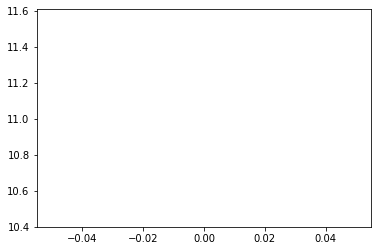

In [25]:
plt.plot(history.epoch, history.history["loss"], label="total loss")
plt.show()

In [30]:
def predict_next_note(notes: np.ndarray, model: tf.keras.Model, temperature=1.0):
    """Generates a note IDs using a trained sequence model."""
    assert temperature > 0
    # Add batch dimension
    inputs = tf.expand_dims(notes, 0)
    predictions = model.predict(inputs)
    pitch_logits = predictions["pitch"]
    pitch_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)
    pitch = tf.squeeze(pitch, axis=-1)

    delay = predictions["delay"]
    duration = predictions["duration"]
    return int(pitch), float(delay), float(duration)

In [39]:
temperature = 3.0
num_predictions = 500

a = random.randint(0, 6000)
print(f"Using starter notes from {a} to {a + 64}...")
starter_notes = np.stack(dataset[a:a + 64])
input_notes = (starter_notes[:seq_length] / np.array([vocab_size]))

generated_notes = []
for _ in range(num_predictions):
    input_note = predict_next_note(input_notes, model, temperature)
    generated_notes.append(input_note)
    input_notes = np.delete(input_notes, 0, axis=0)
    input_notes = np.append(input_notes, np.expand_dims(input_note, axis=0), axis=0)

generated_notes = pd.DataFrame(generated_notes, columns=("pitch", "start", "end"))
generated_notes

Using starter notes from 4181 to 4245...


,pitch,start,end
0,93,0.421906,0.462373
1,49,0.252119,0.475189
2,36,0.294244,0.472228
3,83,0.321562,0.474290
4,30,0.240160,0.471687
5,81,0.343697,0.469752
6,62,0.240724,0.472716
7,25,0.265948,0.473219
8,100,0.356142,0.470473
9,68,0.244691,0.464648


In [40]:
def notes_to_midi(starter_notes, notes: pd.DataFrame, out_file: str):
    pm = pretty_midi.PrettyMIDI()
    starter_instrument = pretty_midi.Instrument(
        program=pretty_midi.instrument_name_to_program("Acoustic Guitar (steel)"))
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program("Acoustic Grand Piano"))

    # Add starter notes
    prev_start = 0
    for note in starter_notes:
        start = prev_start + 0.1
        n = pretty_midi.Note(
            velocity=random.randint(80, 120),
            pitch=int(note[0]),
            start=start,
            end=start + random.random(),
        )
        starter_instrument.notes.append(n)
        prev_start = start
    pm.instruments.append(starter_instrument)

    # Add generated notes
    for i, note in notes.iterrows():
        n = pretty_midi.Note(
            velocity=random.randint(80, 120),
            pitch=int(note["pitch"]),
            start=prev_start + note["start"],
            end=prev_start + note["end"],
        )
        instrument.notes.append(n)

    pm.instruments.append(instrument)
    pm.write(out_file)
    return pm

In [41]:
out_file = f"../output/{int(time.time())}.mid"
out_pm = notes_to_midi(input_notes, generated_notes, out_file=out_file)
print(f"Successfully saved MIDI as {out_file}")

Successfully saved MIDI as ../output/1650244700.mid


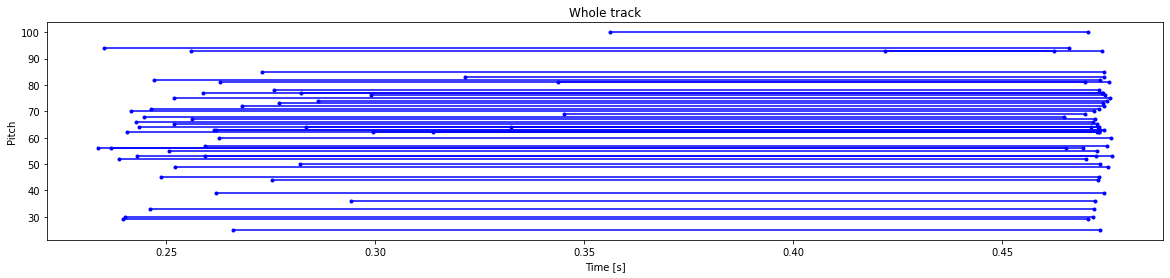

In [42]:
def plot_piano_roll(notes: pd.DataFrame, count=None):
    title = f"Whole track"
    count = len(notes["pitch"])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes["pitch"], notes["pitch"]], axis=0)
    plot_start_stop = np.stack([notes["start"], notes["end"]], axis=0)
    plt.plot(
        plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel("Time [s]")
    plt.ylabel("Pitch")
    _ = plt.title(title)


plot_piano_roll(generated_notes)